In [145]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [291]:
def calcdistsqr(v):
    """Get euclidean distance^2 of v"""
    return np.sum(v**2)

def calcdist(v):
    """Get euclidean distance of v"""
    return np.sqrt(np.sum(v**2))

def argmax_2darray(a):
    return np.unravel_index(a.argmax(), a.shape)

class Agent:
    def __init__(self,age,food,position,speed,lastbreed):
        """
        age = age of agent in iterations
        food = how much food the agent has 'inside' (0=empty, 1=full)
        position = x,y position of the agent
        speed = how fast it can move (tiles/iteration)
        lastbreed = how long ago it last reproduced (iterations)
        """
        self.food = food
        self.age = age
        self.position = position
        self.speed = speed
        self.lastbreed = lastbreed
      
    def breed(self):
        """
        This will either return None, or a new agent object
        """
        new_agent = None
        if (self.lastbreed>self.breedfreq) and (self.food>self.breedfood):
            self.lastbreed = -1
            new_agent = type(self)(0,self.food/2,self.position,self.speed,10)
            self.food = self.food/2
        self.age+=1
        self.lastbreed+=1
        return new_agent
       
    def move(self,env):
        pass
    
    def eat(self,env,agents):
        pass
    
class Rabbit(Agent):
    vision = 5 #how far it can see around current tile
    breedfreq = 20 #how many iterations have to elapse between reproduction events
    breedfood = 20 #how much food has to be eaten to allow reproduction
    maxage = 40 #how long do they live
    
    def __init__(self,age,food,position,speed,lastbreed):
        super().__init__(age,food,position,speed,lastbreed)
        self.eaten = False
        
    def move(self,env):
        """
        rabbit movement:
         - if current cell has no food...
            - will move towards cells with more food
         - DOESN'T move away from nearby foxes
        """
        if env.get_food(self.position)==0:
            food_position = env.get_loc_of_grass(self.position,self.vision) #get the x,y location of nearby food (if any)
            if food_position is not None:
                relative_food_position = food_position - self.position
                if calcdistsqr(relative_food_position)<self.speed**2: #if distance to the food < how far we can go, then
                    self.position = food_position

                else:
                    vect = relative_food_position / calcdist(relative_food_position)
                    self.position = self.position + vect * self.speed
            else:
                #no food in range, pick a random direction...
                d = np.random.rand()*2*np.pi #pick a random direction
                delta = np.round(np.array([np.cos(d),np.sin(d)])* self.speed)

                self.position = self.position + delta
                
        #ensures it's in the environment and rounds to nearest cell
        env.fix_position(self.position)
        
    def eat(self,env,agents):
        """
         - will eat if there's food at location
        """
        if env.get_food(self.position)>0:
            env.reduce_food(self.position)
            self.food += 1
        else:
            self.food -= 1
            
    def draw(self):
        plt.plot(self.position[0],self.position[1],'yx',mew=3)
        
    def die(self):
        """
        Returns true if it needs to expire
        """
        if self.food<=0: return True
        if self.age>self.maxage: return True
        if self.eaten: return True
        return False
        
class Fox(Agent):
    vision = 7 #how far it can see around current tile
    breedfreq = 20 #how many iterations have to elapse between reproduction events
    breedfood = 20 #how much food has to be eaten to allow reproduction
    maxage = 80 #how long do they live
    
    def get_nearby_rabbit(self,position,vision,agents):
        """
        helper function, given the list of agents, find the nearest rabbit, if within 'vision', else None.
        """
        #distances to dead rabbits, or foxes set to infinity.
        sqrdistances = np.sum((np.array([a.position if (type(a)==Rabbit) and (not a.die()) else np.array([-np.inf,-np.inf]) for a in agents])-position)**2,1)
        idx = np.argmin(sqrdistances)
        if sqrdistances[idx]<vision**2:
            return agents[idx]
        else:
            return None
    
    def eat(self,env,agents):
        """     
        Will eat nearby rabbits
        """
        near_rabbit = self.get_nearby_rabbit(self.position,self.vision,agents) #get the x,y location of nearby rabbit (if any)
        if near_rabbit is not None:
            relative_food_position = near_rabbit.position - self.position
            dist = calcdist(relative_food_position)
            if dist<self.speed: #if distance to the food < how far we can go, then
                # probability that fox will kill rabbit is ratio of speed to distance
                kill_prob = 1 - (dist / self.speed)
                if kill_prob>np.random.rand():
                    self.position = near_rabbit.position
                    near_rabbit.eaten = True
                    self.food+=2#near_rabbit.food/2

        #ensures it's in the environment and rounds to nearest cell
        env.fix_position(self.position)
        
    def move(self,env):
        """
         - 
        """
        d = np.random.rand()*2*np.pi #pick a random direction
        delta = np.round(np.array([np.cos(d),np.sin(d)])* self.speed)
        self.position = self.position + delta
            
    def draw(self):
        plt.plot(self.position[0],self.position[1],'sb',markersize=6)
        
    def die(self):
        """
        Returns true if it needs to expire
        """
        
        if self.food<=0: return True
        if self.age>self.maxage: return True
        return False
    
    

class Environment:
    def __init__(self):
        self.maxgrass = 5 #maximum it can grow to
        self.growrate = 300 #how many new items of food added per step
        self.shape = np.array([150,150])        
        self.grass = np.trunc(np.random.rand(*self.shape)*2) #initial grass
        
    def get_food(self,position):        
        return self.grass[int(position[0]),int(position[1])]
    
    def reduce_food(self,position):
        self.grass[int(position[0]),int(position[1])]-=1
    
    def get_loc_of_grass(self,position,vision):
        """
        This finds the location of the cell with the maximum amount of food near 'pos',
        within a circle of 'vision' size.
        For example env.get_dir_of_food(np.array([3,3]),2)
        if two or more cells have the same food then it will select between them randomly.
        """
        
        #we temporarily build a new datastructure to look for the largest grass in with a
        #strip/boundary around the edge of zero food. This feels like the simplest code
        #to solve the edge case problem, but is quite a slow solution.
        boundary = 10
        pos = position + boundary
        grasswithboundary = np.zeros(np.array(self.grass.shape)+boundary*2)
        grasswithboundary[boundary:-boundary,boundary:-boundary] = self.grass
        #we search just a circle within 'vision' tiles of 'pos' (these two commands build that search square)
        searchsquare = grasswithboundary[int(pos[0]-vision):int(pos[0]+vision+1),int(pos[1]-vision):int(pos[1]+vision+1)]
        searchsquare[(np.arange(-vision,vision+1)[:,None]**2 + np.arange(-vision,vision+1)[None,:]**2)>vision**2]=-1
        #this returns the location of that maximum food (with randomness added to equally weight same-food cells)         
        if np.all(searchsquare<=0): return None #no food found
        return argmax_2darray(searchsquare+0.01*np.random.rand(vision*2+1,vision*2+1))+position-vision
        
    def fix_position(self,position):
        position[:] = np.round(position)
        if position[0]<0: position[0]=0
        if position[1]<0: position[1]=0
        if position[0]>self.shape[0]-1: position[0]=self.shape[0]-1
        if position[1]>self.shape[1]-1: position[1]=self.shape[1]-1
            
    def get_random_location(self):
        return np.random.randint(self.shape)
    def grow(self):
        for it in range(self.growrate):
            loc = self.get_random_location()
            if self.grass[loc[0],loc[1]]<self.maxgrass:
                self.grass[loc[0],loc[1]]+=1

    def draw(self):
        plt.imshow(self.grass.T,cmap='gray')
        plt.clim([0,5])

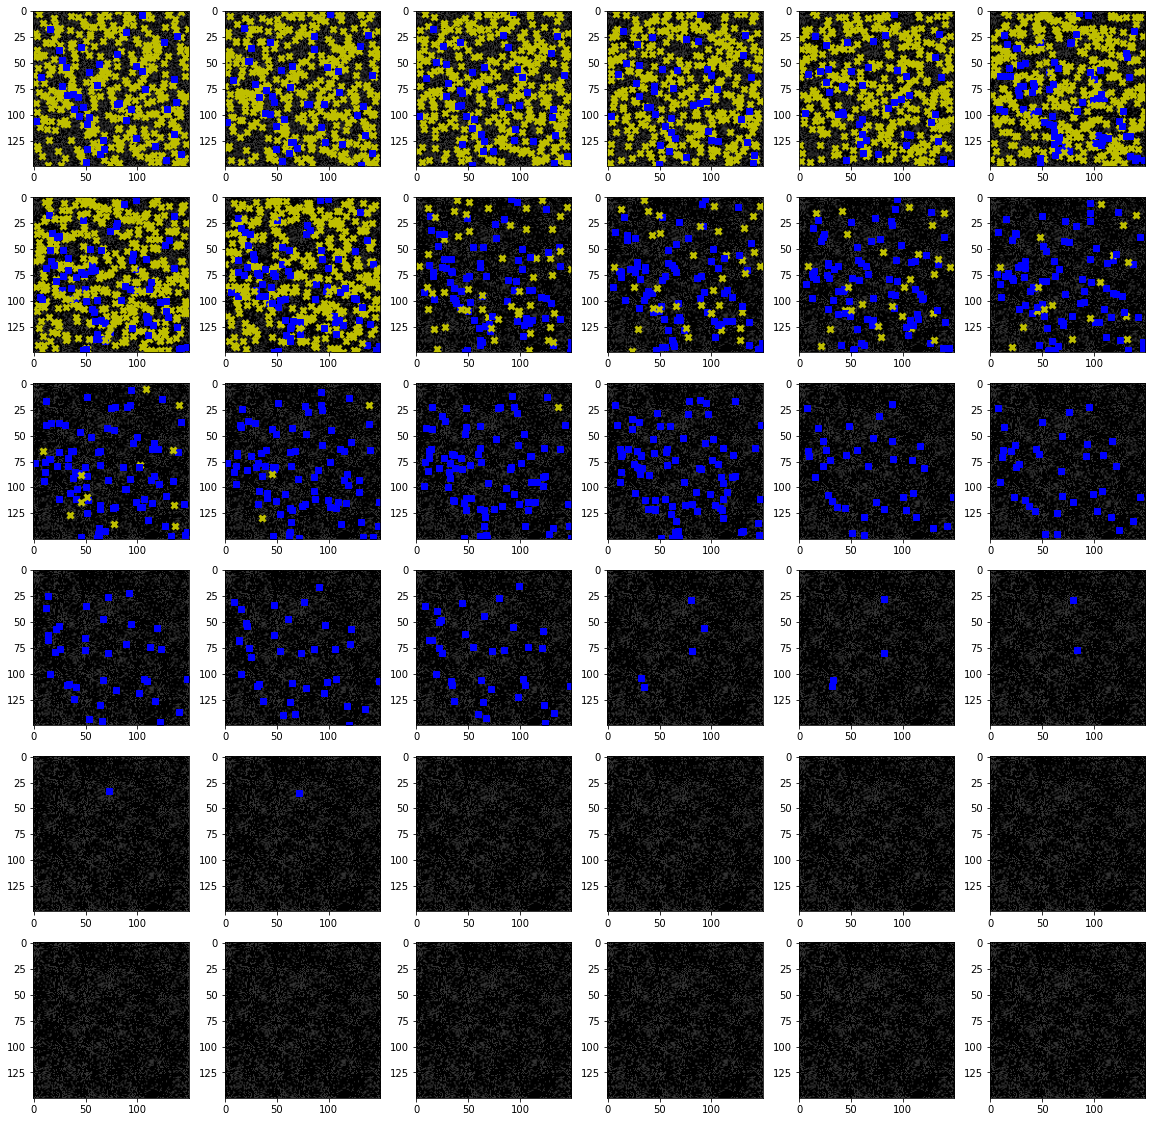

In [292]:
Nrabbits = 40*9
Nfoxes = 5*9
env = Environment()
agents = []
for i in range(Nrabbits):
    r = Rabbit(2,20,env.get_random_location(),1,0)
    agents.append(r)
for i in range(Nfoxes):
    f = Fox(2,20,env.get_random_location(),2,0)
    agents.append(f)

plt.figure(figsize=[20,20])
stepsperdraw = 5
for it in range(36*stepsperdraw):
    for agent in agents:
        agent.move(env)
        agent.eat(env,agents)
        a = agent.breed()
        if a is not None: agents.append(a)
    #removed dead agents
    agents = [a for a in agents if not a.die()]
    
            
            
    if it%stepsperdraw==0:
        plt.subplot(6,6,it/stepsperdraw+1)
        env.draw()
        for agent in agents:
            agent.draw()